Parts of this notebook are taken from Andre Karpathy: https://github.com/karpathy/pytorch-normalizing-flows/blob/master/nflib1.ipynb
and have been modified. 

Using the Embedding rather than an MLP was acknowledged by Jan Francu and Yashas Annadani who I am grateful to. 

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import figure
from matplotlib.backends import backend_agg
from scipy.stats import multivariate_normal
import torch
import itertools

In [24]:
# importing all of the normalizing flows. 
import discrete_flows.disc_utils 
from discrete_flows.made import MADE
from discrete_flows.mlp import MLP
from discrete_flows.embed import EmbeddingLayer
from discrete_flows.disc_models import *

In [25]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generating the training data. A 2D Mixture of 8 Gaussians. 
Storing the data as variable "data" which will then be sampled from. 

In [26]:
def sample_quantized_gaussian_mixture(batch_size):
    """Samples data from a 2D quantized mixture of Gaussians.
    This is a quantized version of the mixture of Gaussians experiment from the
    Unrolled GANS paper (Metz et al., 2017).
    Args:
        batch_size: The total number of observations.
    Returns:
        Tensor with shape `[batch_size, 2]`, where each entry is in
            `{0, 1, ..., max_quantized_value - 1}`, a rounded sample from a mixture
            of Gaussians.
    """
    clusters = np.array([[2., 0.], [np.sqrt(2), np.sqrt(2)],
                                             [0., 2.], [-np.sqrt(2), np.sqrt(2)],
                                             [-2., 0.], [-np.sqrt(2), -np.sqrt(2)],
                                             [0., -2.], [np.sqrt(2), -np.sqrt(2)]])
    assignments = torch.distributions.OneHotCategorical(
            logits=torch.zeros(8, dtype = torch.float32)).sample([batch_size])
    means = torch.matmul(assignments, torch.from_numpy(clusters).float())

    samples = torch.distributions.normal.Normal(loc=means, scale=0.1).sample()
    clipped_samples = torch.clamp(samples, -2.25, 2.25)
    quantized_samples = (torch.round(clipped_samples * 20) + 45).long()
    return quantized_samples

In [27]:
batch_size, sequence_length, vocab_size = 1024, 2, 91
data = sample_quantized_gaussian_mixture(batch_size)

Text(0.5, 1.0, 'Data Distribution')

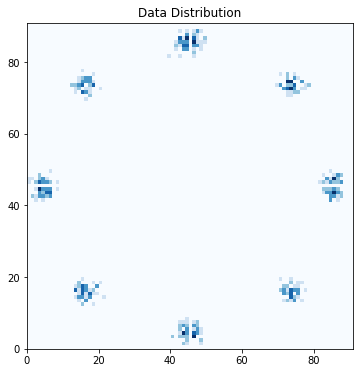

In [28]:
figsize = (6, 6)
fig = fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
#canvas = backend_agg.FigureCanvasAgg(fig)
data_prob_table = np.histogramdd(data, bins=vocab_size)
ax.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
             cmap=cm.get_cmap("Blues", 6),
             origin="lower",
             extent=[0, vocab_size, 0, vocab_size],
             interpolation="nearest")
#fig.show()
ax.set_title("Data Distribution")

## Generating the model

In [38]:
num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'

# This setting was previously used for the MLP and MADE networks. 
nh = 8 # number of hidden units per layer
vector_length = sequence_length*vocab_size

In [39]:
flows = []
for i in range(num_flows):
    if disc_layer_type == 'autoreg':
        
        #layer = EmbeddingLayer([batch_size, sequence_length, vocab_size], output_size=vocab_size)
        # MADE network is much more powerful. 
        layer = MADE([batch_size, sequence_length, vocab_size], vocab_size, [nh, nh, nh])
        
        disc_layer = DiscreteAutoregressiveFlow( layer, temperature, 
                                                    vocab_size )
    
    elif disc_layer_type == 'bipartite':
        # MLP will learn the factorized distribution and not perform well. 
        #layer = MLP(vector_length//2, vector_length//2, nh)
        
        layer = torch.nn.Embedding(vector_length//2, vector_length//2)
        
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, 
                                            vocab_size, vector_length, embedding=True)
        # i%2 flips the parity of the masking. It splits the vector in half and alternates
        # each flow between changing the first half or the second. 
    
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)
model

DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=182, out_features=8, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=8, out_features=8, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=8, out_features=182, bias=True)
        )
      )
    )
  )
)

## Making random base probability distribution

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


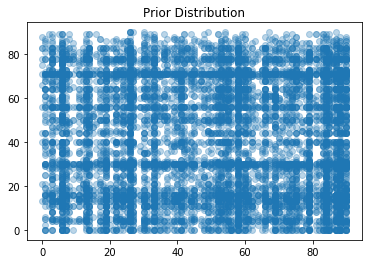

In [40]:
base_log_probs = torch.tensor(torch.randn(sequence_length, vocab_size), requires_grad = True)
base = torch.distributions.OneHotCategorical(logits = base_log_probs)

samps = base.sample((10000,)).argmax(-1)
plt.scatter(samps[:,0], samps[:,1], alpha=0.3)
plt.title("Prior Distribution")
plt.show()

epoch: 0 loss: 10.189916610717773
epoch: 100 loss: 7.999691486358643
epoch: 200 loss: 7.509450435638428
epoch: 300 loss: 7.306369781494141
epoch: 400 loss: 7.230742454528809
epoch: 500 loss: 7.173092842102051
epoch: 600 loss: 7.153774738311768
epoch: 700 loss: 7.147552013397217
epoch: 800 loss: 6.848515033721924
epoch: 900 loss: 6.7698235511779785


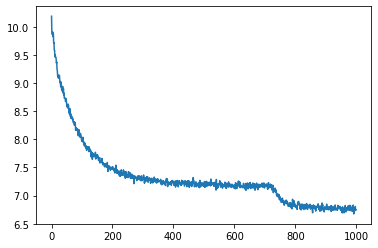

In [41]:
epochs = 1000
learning_rate = 0.01
print_loss_every = epochs//10

losses = []
optimizer = torch.optim.Adam( 
        [
            {'params': model.parameters() , 'lr':learning_rate},
            {'params': base_log_probs, 'lr': learning_rate }
        ])

model.train()
for e in range(epochs):
    x = sample_quantized_gaussian_mixture(batch_size)
    x = F.one_hot(x, num_classes = vocab_size).float()
    
    if disc_layer_type == 'bipartite':
        x= x.view(x.shape[0], -1) #flattening vector
    
    optimizer.zero_grad()
    zs = model.forward(x)
    
    if disc_layer_type == 'bipartite':
        zs = zs.view(batch_size, sequence_length, -1) # adding back in sequence dimension
    
    base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)
    #print(zs.shape, base_log_probs_sm.shape)
    logprob = zs*base_log_probs_sm # zs are onehot so zero out all other logprobs. 
    loss = -torch.sum(logprob)/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if e%print_loss_every==0:
        print('epoch:', e, 'loss:', loss.item())

plt.plot(losses)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


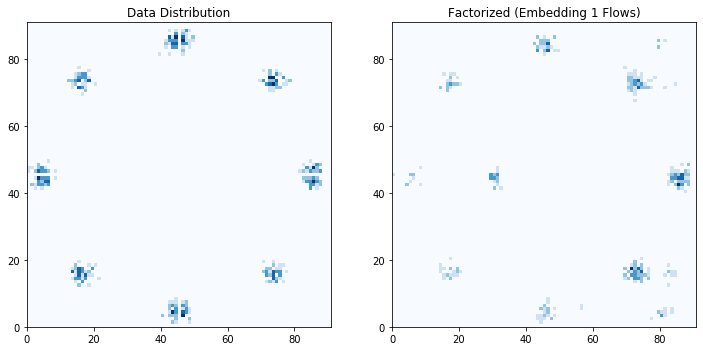

In [42]:
data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
samples = data_distribution.sample([batch_size])
if disc_layer_type == 'bipartite':
    samples = samples.view(samples.shape[0], -1)
samples = model.reverse(samples)
if disc_layer_type == 'bipartite':
    samples = samples.view(batch_size, sequence_length, -1)
data_samples = torch.argmax(samples, axis=-1).detach().numpy()
figsize = (12, 6)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
data_prob_table = np.histogramdd(data, bins=vocab_size)
ax1.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
ax1.set_title("Data Distribution")
ax2.set_title("{} ({} {} Flows)".format(
  "factorized".replace("_", " ").title(),
  "embedding".title(),
  1))
learned_prob_table = np.histogramdd(data_samples, bins=vocab_size)
ax2.imshow(learned_prob_table[0]/np.sum(learned_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
fig.show()
plt.gcf().savefig('figures/Fig2Reproduce.png', dpi=250)

## Additional Analysis

### Mapping from learned prior to data

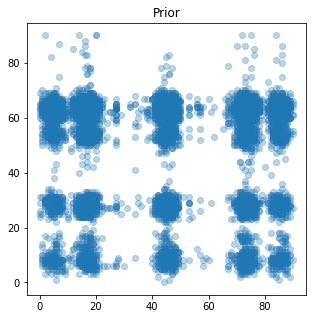

In [29]:
base = torch.distributions.OneHotCategorical( logits = base_log_probs )
plt.figure(figsize=(5,5))
samps = base.sample((10000,)).argmax(-1)
plt.scatter(samps[:,0], samps[:,1], label = 'shifted data', alpha=0.3)
plt.title('Prior')
plt.show()

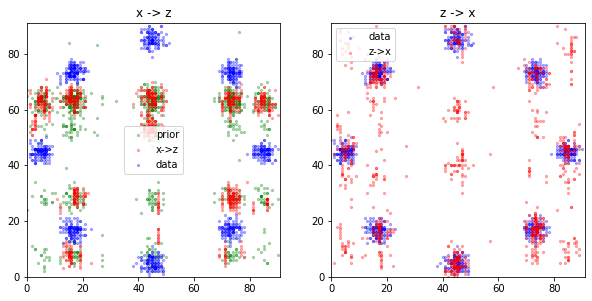

In [35]:
batch_size = 1000
model.eval()
x = sample_quantized_gaussian_mixture(batch_size)
x = F.one_hot(x, num_classes = vocab_size).float()
if disc_layer_type == 'bipartite':
    x = x.view(batch_size, -1)
zs = model.forward(x)
z = zs
if disc_layer_type == 'bipartite':
    z = z.view(batch_size, 2, -1)
    x = x.view(batch_size, 2, -1)

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
p = base.sample((batch_size,)).argmax(-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5, alpha=0.3)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.3)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

if disc_layer_type == 'bipartite':
    z = model.reverse(base.sample((batch_size,)).float().view(batch_size, -1))
    z = z.view(batch_size, 2, -1)
else: 
    z = model.reverse(base.sample((batch_size,)).float())
z = z.detach().numpy().argmax(-1)
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.3)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])
plt.show()

### Plotting just the Z->X

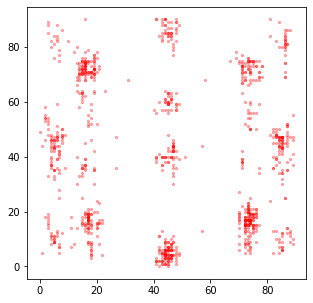

In [36]:
plt.figure(figsize=(5,5))
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.show()

### Heatmap of the Z->X 
NB. The y axes is in the opposite direction

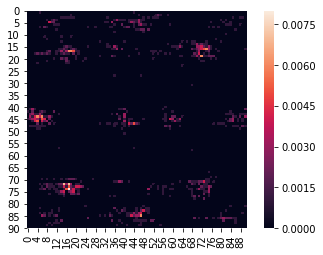

In [37]:
dim = base_log_probs.shape[-1]

heat = np.zeros((dim, dim))
for ind, ex in enumerate(z): 
    heat[ex[0], ex[1] ] += 1

heat = heat/ batch_size
import seaborn as sns;
sns.heatmap(heat, square=True)

### Plotting just the Prior and X->Z

(1000, 2)


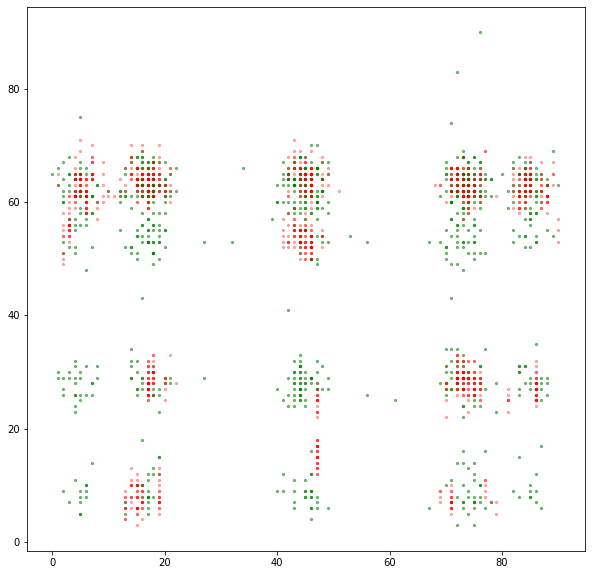

In [41]:
x = sample_quantized_gaussian_mixture(batch_size)
x = F.one_hot(x, num_classes = vocab_size).float()
if disc_layer_type == 'bipartite':
    x = x.view(samp_batch_size, -1)
z = model.forward(x)

if disc_layer_type == 'bipartite':
    z = z.view(samp_batch_size, 2, -1)
    x = x.view(samp_batch_size, 2, -1)

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
print(z.shape)
p = base.sample((samp_batch_size,)).argmax(-1)
plt.figure(figsize=(10,10))

plt.scatter(p[:,0], p[:,1], c='g', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)

### Heatmap of the Prior

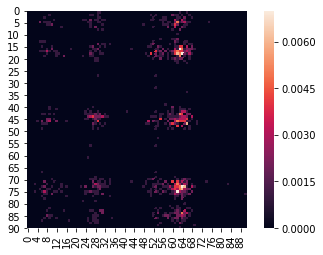

In [42]:
dim = base_log_probs.shape[-1]

heat = np.zeros((dim, dim))
for ind, ex in enumerate(p): 
    heat[ex[0], ex[1] ] += 1

heat = heat/ samp_batch_size
import seaborn as sns;
sns.heatmap(heat, square=True)

### Heatmap of X->Z
This should cover the highest probability regions. 

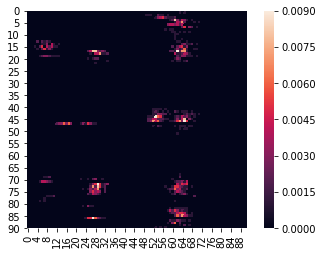

In [43]:
heat = np.zeros((dim, dim))
for ind, ex in enumerate(z): 
    heat[ex[0], ex[1] ] += 1
heat = heat/ samp_batch_size

import seaborn as sns;
sns.heatmap(heat, square=True)

### Looking at the shifts at each position

In [44]:
net = model.flows[0].layer

In [45]:
wloc = net.weight.detach().numpy()
np.argmax(wloc,-1)

array([18, 18,  9, 12, 18, 19, 16, 21, 15, 17, 18, 46, 45, 82, 83, 82, 82,
       46, 47, 82, 46, 46, 47, 79, 46, 46, 52, 17, 21, 44, 50, 79, 25, 38,
       89, 25, 18, 19, 58, 61, 60, 61, 59, 61, 59, 59, 59, 21, 61, 59, 71,
       57, 64, 10, 69, 27, 81, 17, 49, 70, 61,  0, 53, 78,  5, 50, 81, 48,
       81, 81, 45, 82, 47, 45, 46, 46, 46, 84, 82, 81, 16, 71, 17, 16, 18,
       19, 73, 16, 16, 20, 12])

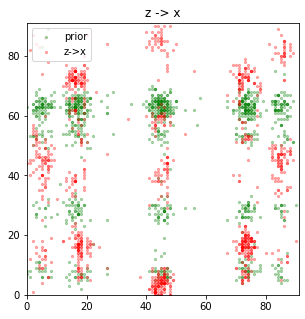

In [47]:
batch_size = 1000
model.eval()
x = sample_quantized_gaussian_mixture(batch_size)
x = F.one_hot(x, num_classes = vocab_size).float()
if disc_layer_type == 'bipartite':
    x = x.view(batch_size, -1)
zs = model.forward(x)
z = zs
if disc_layer_type == 'bipartite':
    z = z.view(batch_size, 2, -1)
    x = x.view(batch_size, 2, -1)

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
p = base.sample((batch_size,)).argmax(-1)
plt.figure(figsize=(10,5))
#plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5, alpha=0.3)

if disc_layer_type == 'bipartite':
    z = model.reverse(base.sample((batch_size,)).float().view(batch_size, -1))
    z = z.view(batch_size, 2, -1)
else: 
    z = model.reverse(base.sample((batch_size,)).float())
z = z.detach().numpy().argmax(-1)

plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.legend(['prior', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])
plt.show()

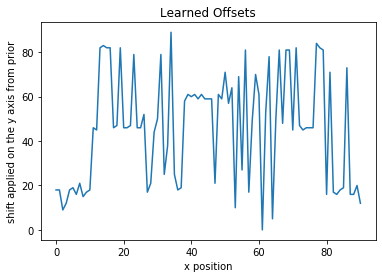

In [48]:
plt.title('Learned Offsets')
plt.plot(np.argmax(wloc,-1))
plt.xlabel('x position')
plt.ylabel('shift applied on the y axis from prior')
plt.show()